#### Import Statements

In [1]:
from IPython.display import Image as IPImage, display
from PIL import Image
import torch
import random
import matplotlib.pyplot as plt
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, AutoModelForCausalLM,
    CLIPProcessor, CLIPModel
)
from collections import defaultdict
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from evaluate import load
from collections import defaultdict

random.seed(42)

#### Image Captioning Model

The following image is used for captioning:


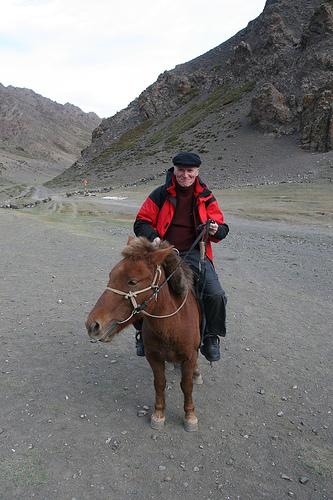

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Generating Captions using Model: blip2-flan-t5-xl


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1. a man riding a horse in the mountains
2. a man riding a small horse in the mountains

Generating Captions using Model: blip2-opt-6.7b


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

1. a man in a red jacket riding a small horse 
2. a man in a red jacket riding a horse 

Generating Captions using Model: blip-image-captioning-base
1. a man on a horse in the mountains
2. a man riding a horse on a dirt road

Generated Captions from All Models:
1. a man on a horse in the mountains
2. a man riding a horse in the mountains
3. a man riding a small horse in the mountains
4. a man riding a horse on a dirt road
5. a man in a red jacket riding a small horse 
6. a man in a red jacket riding a horse 

Best Caption Selected by CLIP:
a man in a red jacket riding a small horse 

CLIP Probabilities:
1. a man on a horse in the mountains --> 0.0638
2. a man riding a horse in the mountains --> 0.0959
3. a man riding a small horse in the mountains --> 0.3240
4. a man riding a horse on a dirt road --> 0.0074
5. a man in a red jacket riding a small horse  --> 0.4262
6. a man in a red jacket riding a horse  --> 0.0827


In [2]:
def generate_blip2_captions(image_path, num_beams=5, num_return_sequences=3):
    try:
        processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl", local_files_only=True)
        model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", local_files_only=True)
    except:
        processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
        model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
    
    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path.convert("RGB")
    inputs = processor(image, return_tensors="pt")
    outputs = model.generate(**inputs, num_beams=num_beams, num_return_sequences=num_return_sequences)
    return [processor.decode(o, skip_special_tokens=True) for o in outputs]

def generate_blip2_opt_captions(image_path, num_beams=5, num_return_sequences=3):
    try:
        processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-6.7b", local_files_only=True)
        model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-6.7b", local_files_only=True)
    except:
        processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-6.7b")
        model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-6.7b")

    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path.convert("RGB")
    inputs = processor(image, return_tensors="pt")

    outputs = model.generate(
        **inputs,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences
    )

    return [processor.decode(output, skip_special_tokens=True) for output in outputs]

def generate_blip_captions(image_path, num_beams=5, num_return_sequences=3):
    try:
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base", local_files_only=True)
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", local_files_only=True)
    except:
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path.convert("RGB")
    inputs = processor(image, return_tensors="pt")
    outputs = model.generate(**inputs, num_beams=num_beams, num_return_sequences=num_return_sequences)
    return [processor.decode(o, skip_special_tokens=True) for o in outputs]

def get_clip_best_caption(image_path, candidate_captions):
    try:
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", local_files_only=True)
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", local_files_only=True)
    except:
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path.convert("RGB")
    inputs = processor(text=candidate_captions, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    
    best_idx = torch.argmax(probs, dim=1).item()
    return candidate_captions[best_idx], probs, candidate_captions

def main_pipeline(image_path):
    print("The following image is used for captioning:")
    display(IPImage(filename=image_path))
    print("Generating Captions using Model: blip2-flan-t5-xl")
    blip2_caps = generate_blip2_captions(image_path, num_beams=3, num_return_sequences=2)
    blip2_caps = [cap.replace('\n', ' ') for cap in blip2_caps]
    for i, cap in enumerate(blip2_caps):
        print(f"{i+1}. {cap}")
    print("=" * 82)

    print("\nGenerating Captions using Model: blip2-opt-6.7b")
    blip2_opt_caps = generate_blip2_opt_captions(image_path, num_beams=3, num_return_sequences=2)
    blip2_opt_caps = [cap.replace('\n', ' ') for cap in blip2_opt_caps]
    for i, cap in enumerate(blip2_opt_caps):
        cap.replace('\n', ' ')
        print(f"{i+1}. {cap}")
    print("=" * 82)

    print("\nGenerating Captions using Model: blip-image-captioning-base")
    blip_caps = generate_blip_captions(image_path, num_beams=3, num_return_sequences=2)
    blip_caps = [cap.replace('\n', ' ') for cap in blip_caps]
    for i, cap in enumerate(blip_caps):
        print(f"{i+1}. {cap}")
    print("=" * 82)

    candidate_captions = list(set(blip2_caps + blip2_opt_caps + blip_caps))

    print("\nGenerated Captions from All Models:")
    for i, cap in enumerate(candidate_captions):
        print(f"{i+1}. {cap}")

    print("=" * 82)

    best_caption, probabilities, _ = get_clip_best_caption(image_path, candidate_captions)
    
    print("\nBest Caption Selected by CLIP:")
    print(best_caption)

    print("\nCLIP Probabilities:")
    for i, (caption, prob) in enumerate(zip(candidate_captions, probabilities[0])):
        print(f"{i+1}. {caption} --> {prob.item():.4f}")

    return [best_caption] if best_caption else []

if __name__ == "__main__":
    image_path = "./sampling_img_kc/flickr30k_sampled_images/284105062.jpg"
    main_pipeline(image_path)

#### Evaluation of the Image Captioning Model

In [3]:
dataset = load_dataset("nlphuji/flickr30k")

#### Dataset Statistics

In [4]:
def dataset_stats(dataset):
    for split in dataset:
        data = dataset[split]
        print(f"=== {split.upper()} SPLIT ===")
        print(f"Total Samples       : {len(data)}")

        caption_lengths = []
        total_captions = 0

        for example in data:
            captions = example['caption']
            total_captions += len(captions)
            for cap in captions:
                caption_lengths.append(len(cap.split()))

        print(f"Total Captions      : {total_captions}")
        print(f"Avg Caption Length  : {sum(caption_lengths)/len(caption_lengths):.2f} words")
        print(f"Min Caption Length  : {min(caption_lengths)}")
        print(f"Max Caption Length  : {max(caption_lengths)}")
        print()

In [5]:
dataset_stats(dataset)

=== TEST SPLIT ===
Total Samples       : 31014
Total Captions      : 155070
Avg Caption Length  : 12.27 words
Min Caption Length  : 2
Max Caption Length  : 78



#### Splitting the dataset

In [6]:
dataset = load_dataset("nlphuji/flickr30k", split="test")

train_val_test = dataset.train_test_split(test_size=0.2, seed=42)
train_data = train_val_test['train']
temp_data = train_val_test['test']

val_test_split = temp_data.train_test_split(test_size=0.5, seed=42)
val_data = val_test_split['train']
test_data = val_test_split['test']

#### Print random example

In [7]:
example = train_data[0]
print(example)
print(type(example['caption']), example['caption'])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=417x500 at 0x11203C451F0>, 'caption': ['Three people are standing on the dock of a boat looking at something off-camera.', 'Three men stand atop a boat from Seattle Washington.', 'Three people stand on a boat that is docked.', 'A blue and white sailboat sits by a dock.', 'A few people park their boat at a dock.'], 'sentids': ['17530', '17531', '17532', '17533', '17534'], 'split': 'train', 'img_id': '3506', 'filename': '2125216241.jpg'}
<class 'list'> ['Three people are standing on the dock of a boat looking at something off-camera.', 'Three men stand atop a boat from Seattle Washington.', 'Three people stand on a boat that is docked.', 'A blue and white sailboat sits by a dock.', 'A few people park their boat at a dock.']


#### Printing random image with captions

In [8]:
def show_random_image_with_captions(dataset_split):
    sample = random.choice(dataset_split)
    img = sample['image']
    target_img_id = sample['img_id']

    all_captions = []
    for row in dataset_split:
        if row['img_id'] == target_img_id:
            all_captions.extend(row['caption'])

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image ID: {target_img_id}")
    plt.show()

    print("Captions:")
    for i, cap in enumerate(all_captions):
        print(f"{i+1}. {cap}")

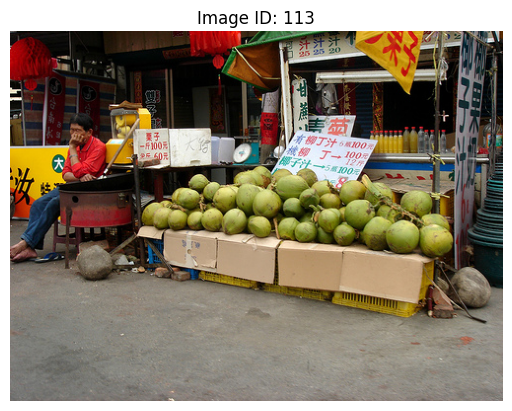

Captions:
1. A Asian male wearing a red shirt is sitting next to a grocery stand selling fruits.
2. Man in red shirt is sitting next to fruit that is for sale.
3. A man in a red shirt is sitting by fruit for sale.
4. A man in a red shirt sits next to a fruit stand.
5. An oriental man selling produce.


In [9]:
show_random_image_with_captions(train_data)

#### Captions per image

In [10]:
def captions_per_image(dataset_split):
    image_caption_count = defaultdict(int)

    for row in dataset_split:
        img_id = row['img_id']
        captions = row['caption']
        image_caption_count[img_id] += len(captions)

    caption_counts = list(image_caption_count.values())

    print("=== Caption Distribution Per Image ===")
    print(f"Total Unique Images : {len(image_caption_count)}")
    print(f"Total Captions      : {sum(caption_counts)}")
    print(f"Avg Captions/Image  : {sum(caption_counts)/len(caption_counts):.2f}")
    print(f"Min Captions/Image  : {min(caption_counts)}")
    print(f"Max Captions/Image  : {max(caption_counts)}")

In [11]:
captions_per_image(train_data)

=== Caption Distribution Per Image ===
Total Unique Images : 24811
Total Captions      : 124055
Avg Captions/Image  : 5.00
Min Captions/Image  : 5
Max Captions/Image  : 5


#### Computing BLEU and Rouge scores

In [12]:
rouge = load("rouge")
smoothie = SmoothingFunction().method4

def evaluate_on_flickr(model_fn, dataset_split, max_samples=100):
    bleu_scores = []
    rouge_inputs = {"predictions": [], "references": []}

    image_captions = defaultdict(list)
    image_objects = {}

    for item in dataset_split:
        img_id = item['img_id']
        filename = item['filename']
        image_captions[filename].extend(item['caption'])
        image_objects[filename] = item['image']

    for idx, (filename, references) in enumerate(image_captions.items()):
        if idx >= max_samples:
            break

        image = image_objects[filename]
        generated = model_fn(image)

        if not generated:
            continue

        generated_caption = generated[0].replace('\n', ' ').strip().lower()
        
        formatted_refs = [ref.lower().strip().split() for ref in references]
        bleu = sentence_bleu(formatted_refs, generated_caption.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu)

        rouge_inputs["predictions"].append(generated_caption)
        rouge_inputs["references"].append(" ".join(references))

    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    rouge_scores = rouge.compute(predictions=rouge_inputs["predictions"],
                                 references=rouge_inputs["references"])

    return avg_bleu, rouge_scores

#### BLEU and ROUGE scores for BLIP-2 model

In [13]:
avg_bleu, rouge_scores = evaluate_on_flickr(generate_blip2_captions, train_data, max_samples=10)
print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
print("ROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Average BLEU Score: 0.2198
ROUGE Scores:
rouge1: 0.2169
rouge2: 0.1128
rougeL: 0.1845
rougeLsum: 0.1842


#### BLEU and ROUGE scores for BLIP-2 OPT model

In [14]:
avg_bleu, rouge_scores = evaluate_on_flickr(generate_blip2_opt_captions, train_data, max_samples=10)
print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
print("ROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Average BLEU Score: 0.2171
ROUGE Scores:
rouge1: 0.2367
rouge2: 0.1234
rougeL: 0.2127
rougeLsum: 0.2127


#### BLEU and Rouge scores for BLIP model

In [15]:
avg_bleu, rouge_scores = evaluate_on_flickr(generate_blip_captions, train_data, max_samples=10)
print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
print("ROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")


Average BLEU Score: 0.1546
ROUGE Scores:
rouge1: 0.1869
rouge2: 0.0829
rougeL: 0.1440
rougeLsum: 0.1439


#### BLEU and Rouge scores for CLIP model

In [16]:
def generate_clip_caption(image_path):
    blip2_caps = generate_blip2_captions(image_path, num_beams=3, num_return_sequences=2)
    blip2_caps = [cap.replace('\n', ' ') for cap in blip2_caps]
    
    blip2_opt_caps = generate_blip2_opt_captions(image_path, num_beams=3, num_return_sequences=2)
    blip2_opt_caps = [cap.replace('\n', ' ') for cap in blip2_opt_caps]

    blip_caps = generate_blip_captions(image_path, num_beams=3, num_return_sequences=2)
    blip_caps = [cap.replace('\n', ' ') for cap in blip_caps]

    candidate_captions = list(set(blip2_caps + blip2_opt_caps + blip_caps))
    best_caption, probabilities, _ = get_clip_best_caption(image_path, candidate_captions)
    return [best_caption] if best_caption else []


In [17]:
avg_bleu, rouge_scores = evaluate_on_flickr(generate_clip_caption, train_data, max_samples=10)
print(f"\nAverage BLEU Score: {avg_bleu:.4f}")
print("ROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Average BLEU Score: 0.2753
ROUGE Scores:
rouge1: 0.2405
rouge2: 0.1308
rougeL: 0.2127
rougeLsum: 0.2126
